In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import glob as gb

In [18]:
img=cv2.imread('../input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithMask/1163.png')
img.shape

(36, 36, 3)

In [19]:
train_dir='../input/face-mask-12k-images-dataset/Face Mask Dataset/Train'
test_dir ='../input/face-mask-12k-images-dataset/Face Mask Dataset/Test'
valid_dir='../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation'

In [20]:
from keras.applications.mobilenet_v2 import preprocess_input
size=100
import tensorflow as tf
train_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True,
    preprocessing_function=preprocess_input,
).flow_from_directory(train_dir,batch_size=64,target_size=(size,size),subset="training",shuffle=True)

Found 10000 images belonging to 2 classes.


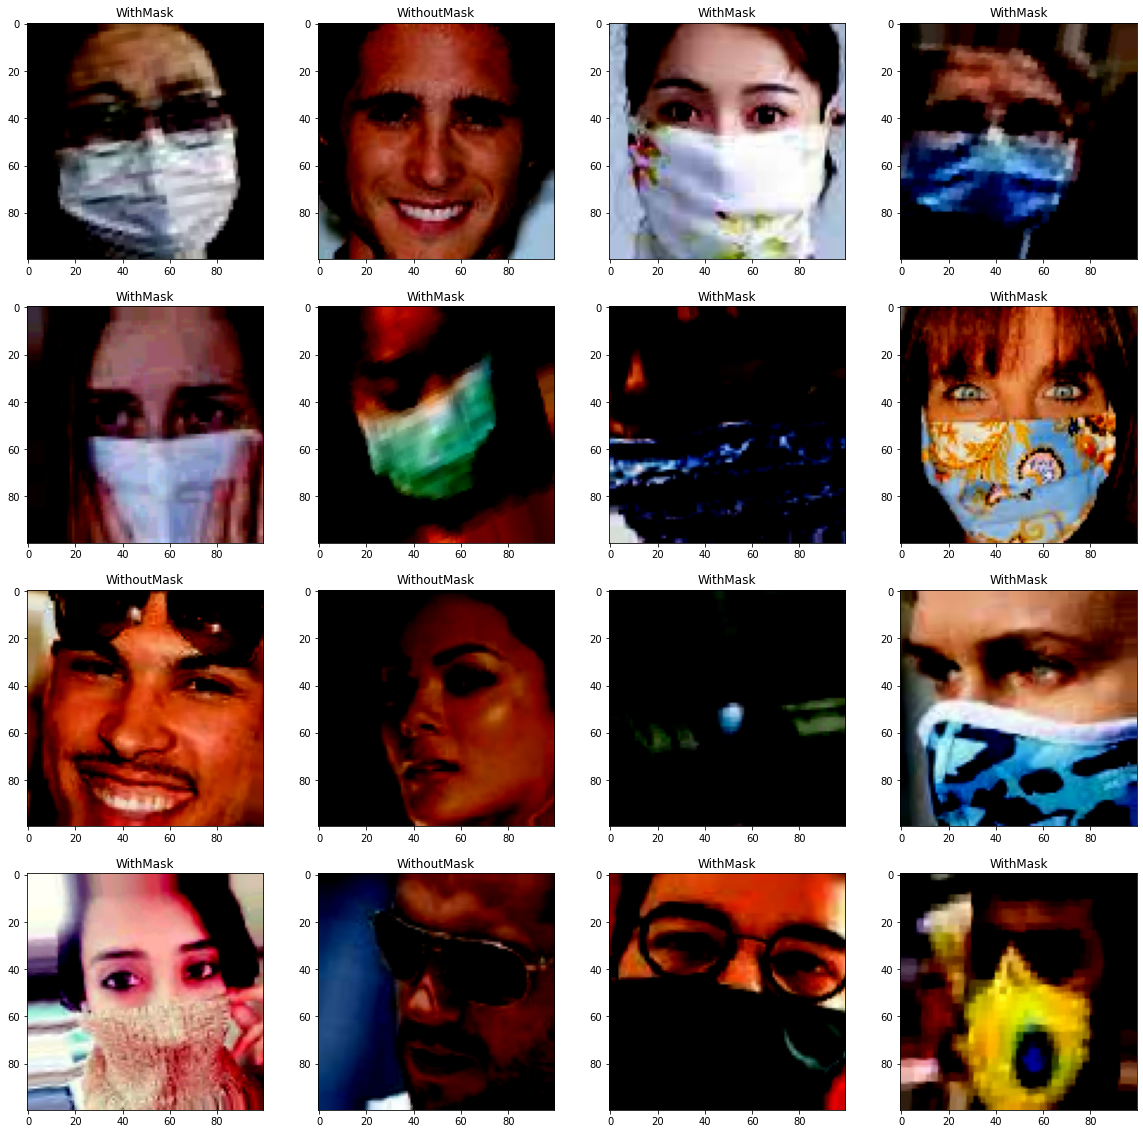

In [21]:
classes=list(train_generator.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in train_generator:
    # create a grid of 3x3 images
    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])
    # show the plot
    plt.show()
    break

In [22]:
valid_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
).flow_from_directory(valid_dir,batch_size=16,target_size=(size,size),shuffle=False)


Found 800 images belonging to 2 classes.


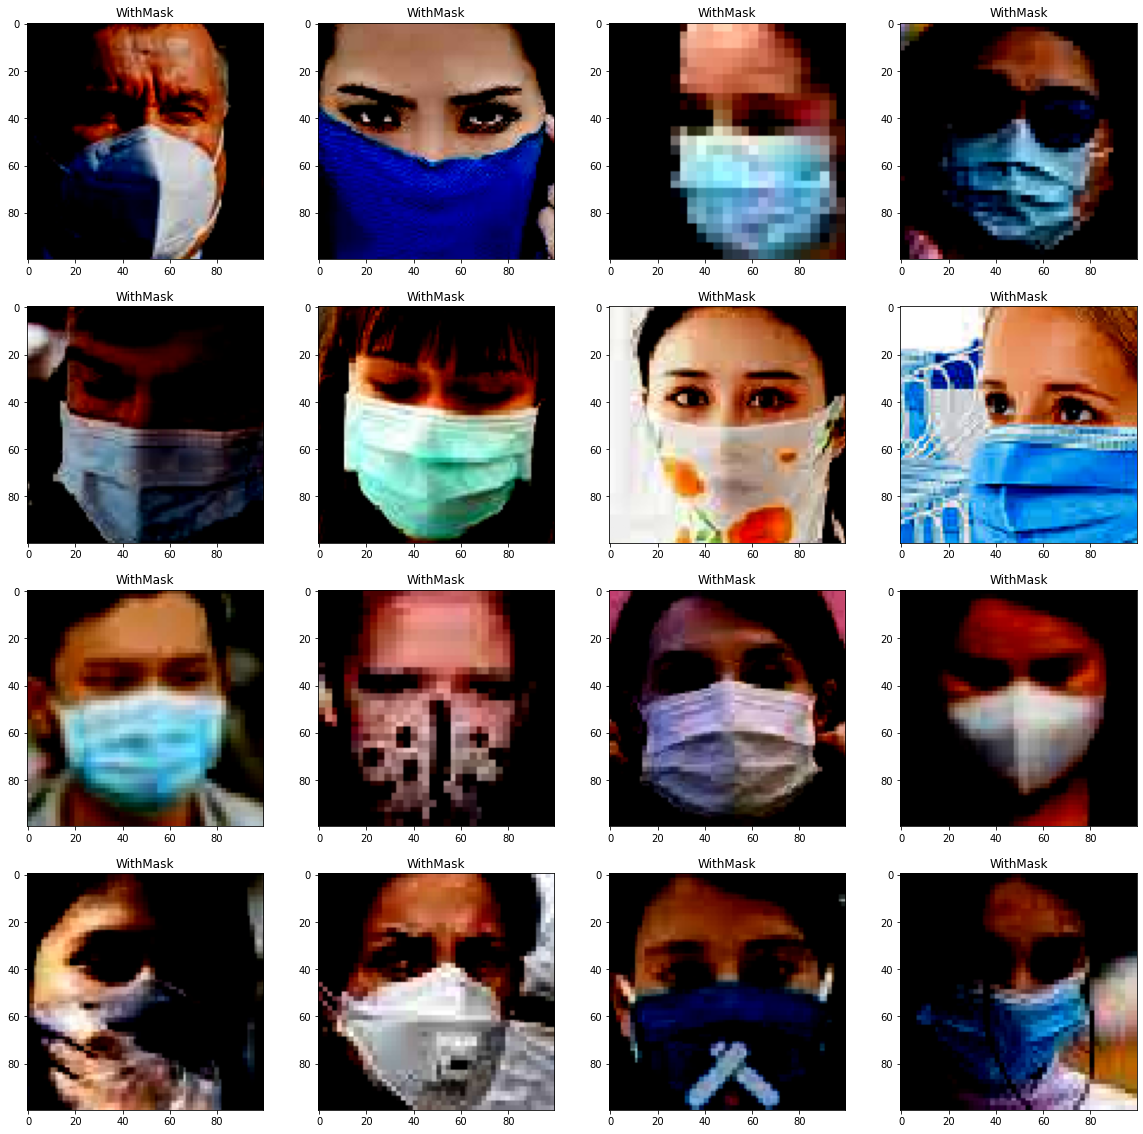

In [23]:
classes=list(valid_generator.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in valid_generator:
    # create a grid of 3x3 images
    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])
    # show the plot
    plt.show()
    break

In [24]:
test_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(test_dir,batch_size=16,target_size=(size,size),shuffle=False)



Found 992 images belonging to 2 classes.


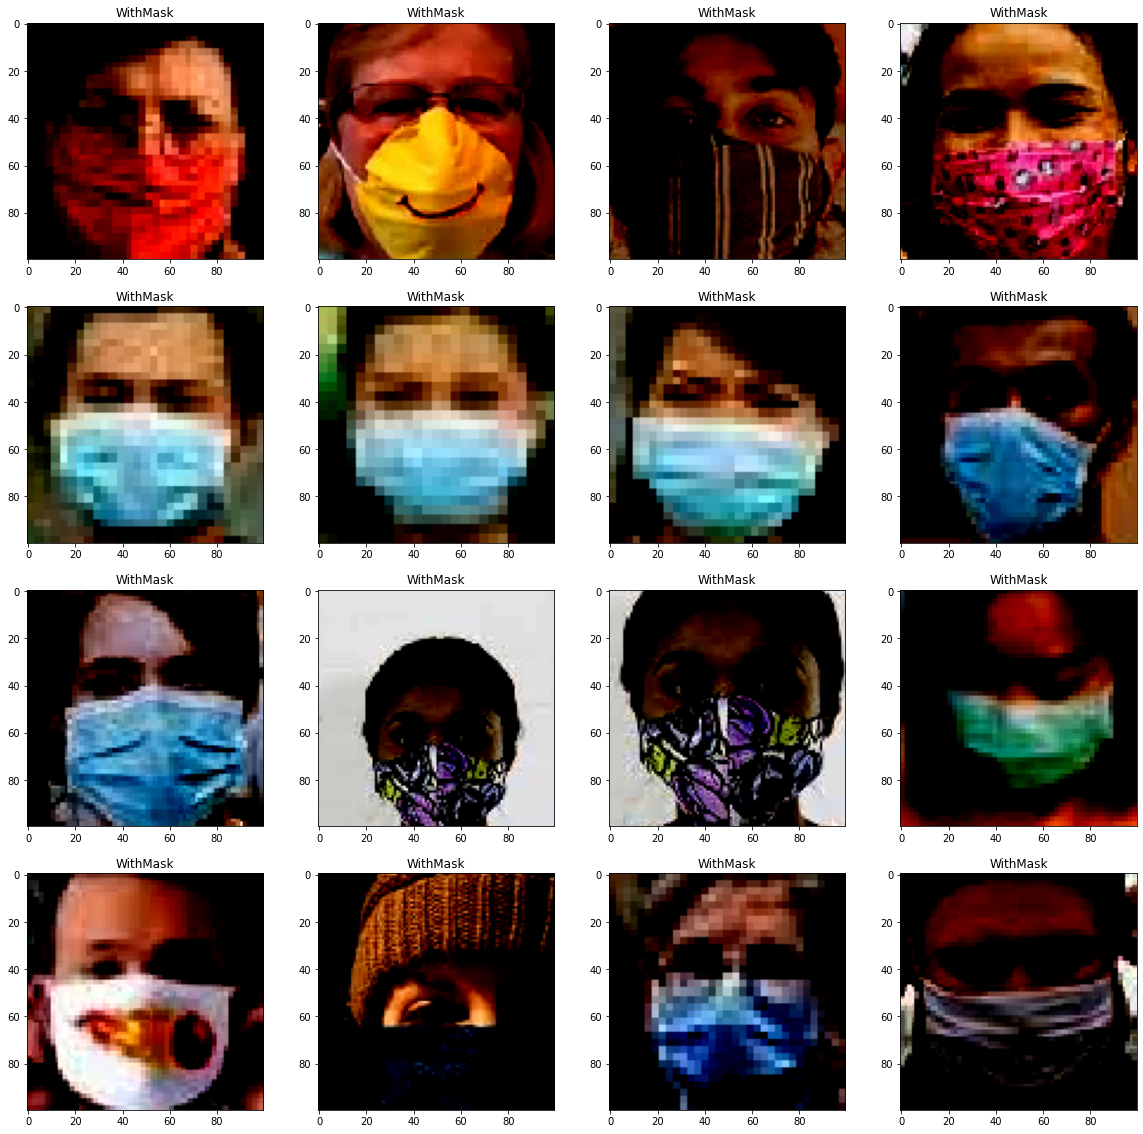

In [25]:

classes=list(test_generator.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in test_generator:
    # create a grid of 3x3 images
    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])
    # show the plot
    plt.show()
    break

In [26]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense ,Flatten ,Conv2D ,MaxPooling2D ,Dropout ,BatchNormalization ,GlobalMaxPool2D
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint

In [27]:
optimizer_adam=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.99)
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('mask_detector.model',monitor='val_loss',verbose=1,save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_check]

In [28]:
from keras.applications.mobilenet_v2 import MobileNetV2
mb=MobileNetV2(include_top=False,input_shape=(size,size,3),weights='imagenet')
mb.trainable=False


In [29]:
model=Sequential([
                  mb,
                  Flatten(),
                  Dense(256,activation='relu'),
                  Dense(128,activation='relu'),
                  Dense(2,activation='softmax',kernel_initializer='glorot_normal')
])

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 20480)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               5243136   
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 258       
Total params: 7,534,274
Trainable params: 5,276,290
Non-trainable params: 2,257,984
_________________________________________________________________


In [33]:
model.compile(optimizer=optimizer_adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [34]:
history=model.fit(train_generator,validation_data=valid_generator,epochs=100,batch_size=64,
                  steps_per_epoch=len(train_generator)//64,validation_steps=len(valid_generator)//16,
                  callbacks=callback, verbose=1)

Epoch 1/100
2/2 [==============================] - 5s 2s/step - loss: 6.3130 - accuracy: 0.3802 - val_loss: 1.9278e-04 - val_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 0.00019, saving model to mask_detector.model
Epoch 2/100
2/2 [==============================] - 1s 610ms/step - loss: 1.4661 - accuracy: 0.8594 - val_loss: 2.3842e-07 - val_accuracy: 1.0000

Epoch 00002: val_loss improved from 0.00019 to 0.00000, saving model to mask_detector.model
Epoch 3/100
2/2 [==============================] - 1s 657ms/step - loss: 0.0144 - accuracy: 0.9896 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

Epoch 00003: val_loss improved from 0.00000 to 0.00000, saving model to mask_detector.model
Epoch 4/100
2/2 [==============================] - 1s 590ms/step - loss: 0.3356 - accuracy: 0.9896 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/100
2/2 [==============================] - 1s 619ms/step - loss: 1.6479 - accuracy: 0.93

In [35]:
loss,acc=model.evaluate(test_generator)

62/62 [==============================] - 2s 31ms/step - loss: 1.6234 - accuracy: 0.9446


In [36]:
loss,acc

(1.6233618259429932, 0.944556474685669)

In [37]:
predictions = model.predict(test_generator)

In [38]:
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [39]:
predictions=predictions.argmax(axis=1)

In [40]:
predictions[0]

0

In [42]:
from sklearn.metrics import classification_report
print(classification_report(test_generator.classes, predictions))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       483
           1       1.00      0.89      0.94       509

    accuracy                           0.94       992
   macro avg       0.95      0.95      0.94       992
weighted avg       0.95      0.94      0.94       992



<AxesSubplot:>

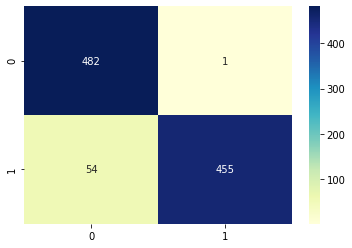

In [44]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_generator.classes, predictions)

sns.heatmap(cm,  annot=True, fmt="d",cmap="YlGnBu")

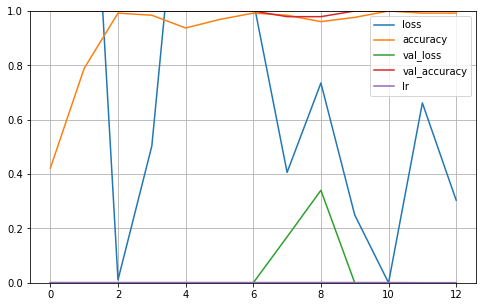

In [45]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()